In [1]:
# pip install jupyter matplotlib

import itertools
import os

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
from multispecies_whale_detection import front_end

In [3]:
from multispecies_whale_detection import dataset

In [4]:
base_dir = os.path.expanduser('~/tmp/examplegen/shuffled_0318')
batch_size = 128
sample_rate = 24000.0
class_names = ['Orca', 'SRKW', 'IBKW', 'J', 'L', 'K', 'NRKW', 'HUMP', 'BG']
window_duration = 2.0

def configured_window_dataset(
  input_subdirectory: str,
  windowing: dataset.Windowing,
) -> tf.data.Dataset:
    """Creates a Dataset, binding arguments shared by train and validation."""
    return dataset.new_window_dataset(
        tfrecord_filepattern=os.path.join(base_dir, 'input', input_subdirectory,
                                          'tfrecords-*'),
        windowing=windowing,
        duration=window_duration,
        class_names=class_names,
        min_overlap=0.25,
    )

def apply_rejection(dataset, rate):
    dataset = dataset.rejection_resample(
       class_func=lambda _, labels: tf.cast(labels[class_names.index('BG')], tf.int32),
       target_dist=[1.0 - rate, rate],
    )
    dataset = dataset.map(lambda _, orig: orig)
    return dataset

train_dataset = configured_window_dataset(
  'train',
  dataset.RandomWindowing(1),
).cache().repeat()
# Comment out to turn rejection resampling off.
#train_dataset = apply_rejection(train_dataset, rate=0.1)
train_dataset = train_dataset.shuffle(batch_size * 4).batch(batch_size).prefetch(1)


2022-03-18 15:10:42.083822: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 15:10:42.724476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13598 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:18:00.0, compute capability: 7.5


In [5]:
model = tf.keras.Sequential([
      front_end.Spectrogram(
          front_end.SpectrogramConfig(
              sample_rate=sample_rate,
              frame_seconds=0.05,
              hop_seconds=0.025,
              normalization=front_end.NoiseFloorConfig(),
              frequency_scaling=front_end.MelScalingConfig(
                  lower_edge_hz=125.0,
                  num_mel_bins=64,
              ))),
      front_end.SpectrogramToImage(),
  ])

In [6]:
iter_train = iter(train_dataset)

In [7]:
waveform, labels = next(iter_train)

In [8]:
(waveform.shape, labels.shape)

(TensorShape([128, 48000]), TensorShape([128, 9]))

In [9]:
images = model(waveform)

2022-03-18 15:10:45.474883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [10]:
(tf.math.reduce_mean(images), tf.math.reduce_std(images), tf.math.reduce_min(images), tf.math.reduce_max(images))

(<tf.Tensor: shape=(), dtype=float32, numpy=46.643997>,
 <tf.Tensor: shape=(), dtype=float32, numpy=40.12796>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-230.24544>,
 <tf.Tensor: shape=(), dtype=float32, numpy=539.70276>)

In [11]:
images.shape

TensorShape([128, 79, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/whaleproject-gts/tmp/whale_env/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


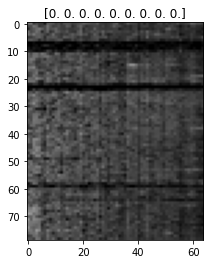

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


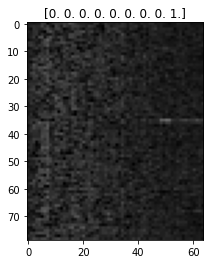

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


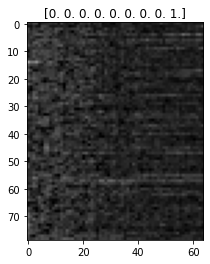

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


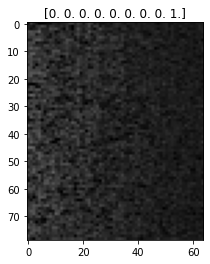

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


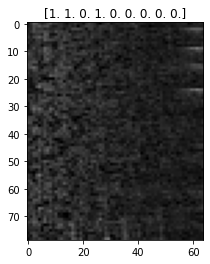

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


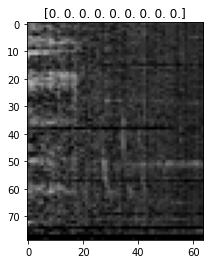

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


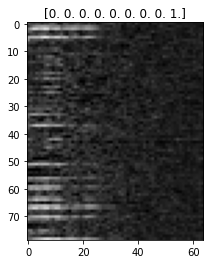

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


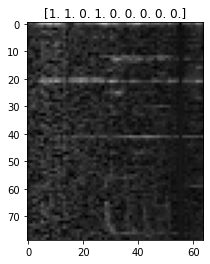

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


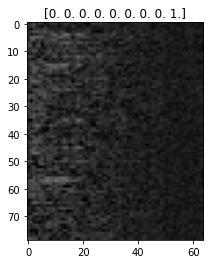

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


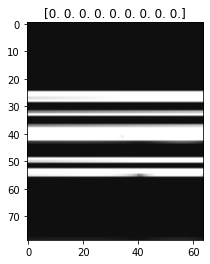

In [12]:
offset = 20
limit = 10

for image, label_batch in itertools.islice(zip(images, labels), offset, offset +limit):
    plt.imshow(tf.cast(image, tf.int32))
    plt.title(label_batch.numpy())
    plt.show()

In [13]:
batch_counts = []
for _, label_batch in itertools.islice(iter(train_dataset), 500):
    batch_counts.append(tf.math.reduce_sum(label_batch, axis=0))
batch_counts = tf.stack(batch_counts)

2022-03-18 15:10:50.323110: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
batch_counts.shape

TensorShape([500, 9])

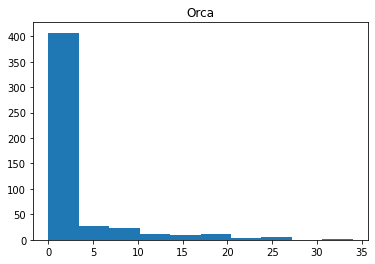

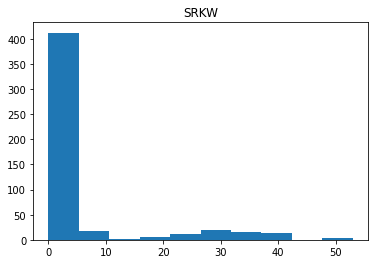

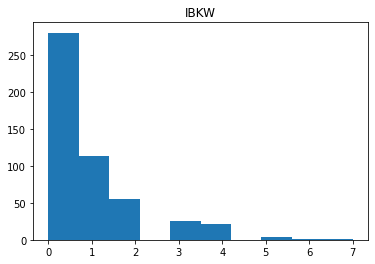

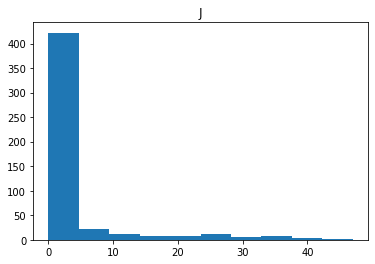

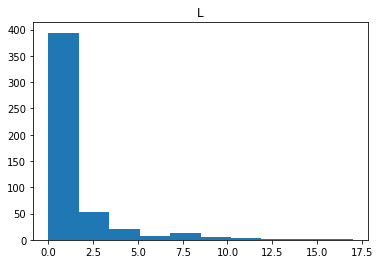

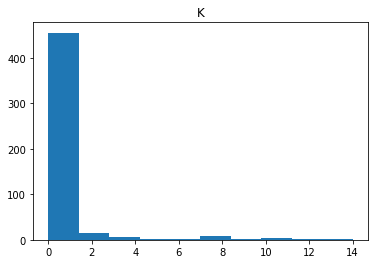

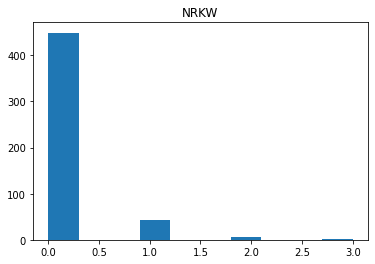

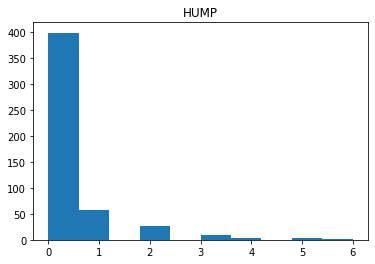

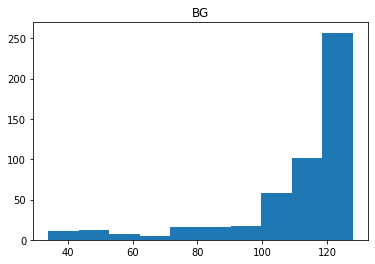

In [15]:
num_classes = batch_counts.shape[-1]
for class_index in range(num_classes):
    class_counts = batch_counts[:, class_index].numpy()
    plt.hist(class_counts)
    plt.title(class_names[class_index])
    plt.show()